[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

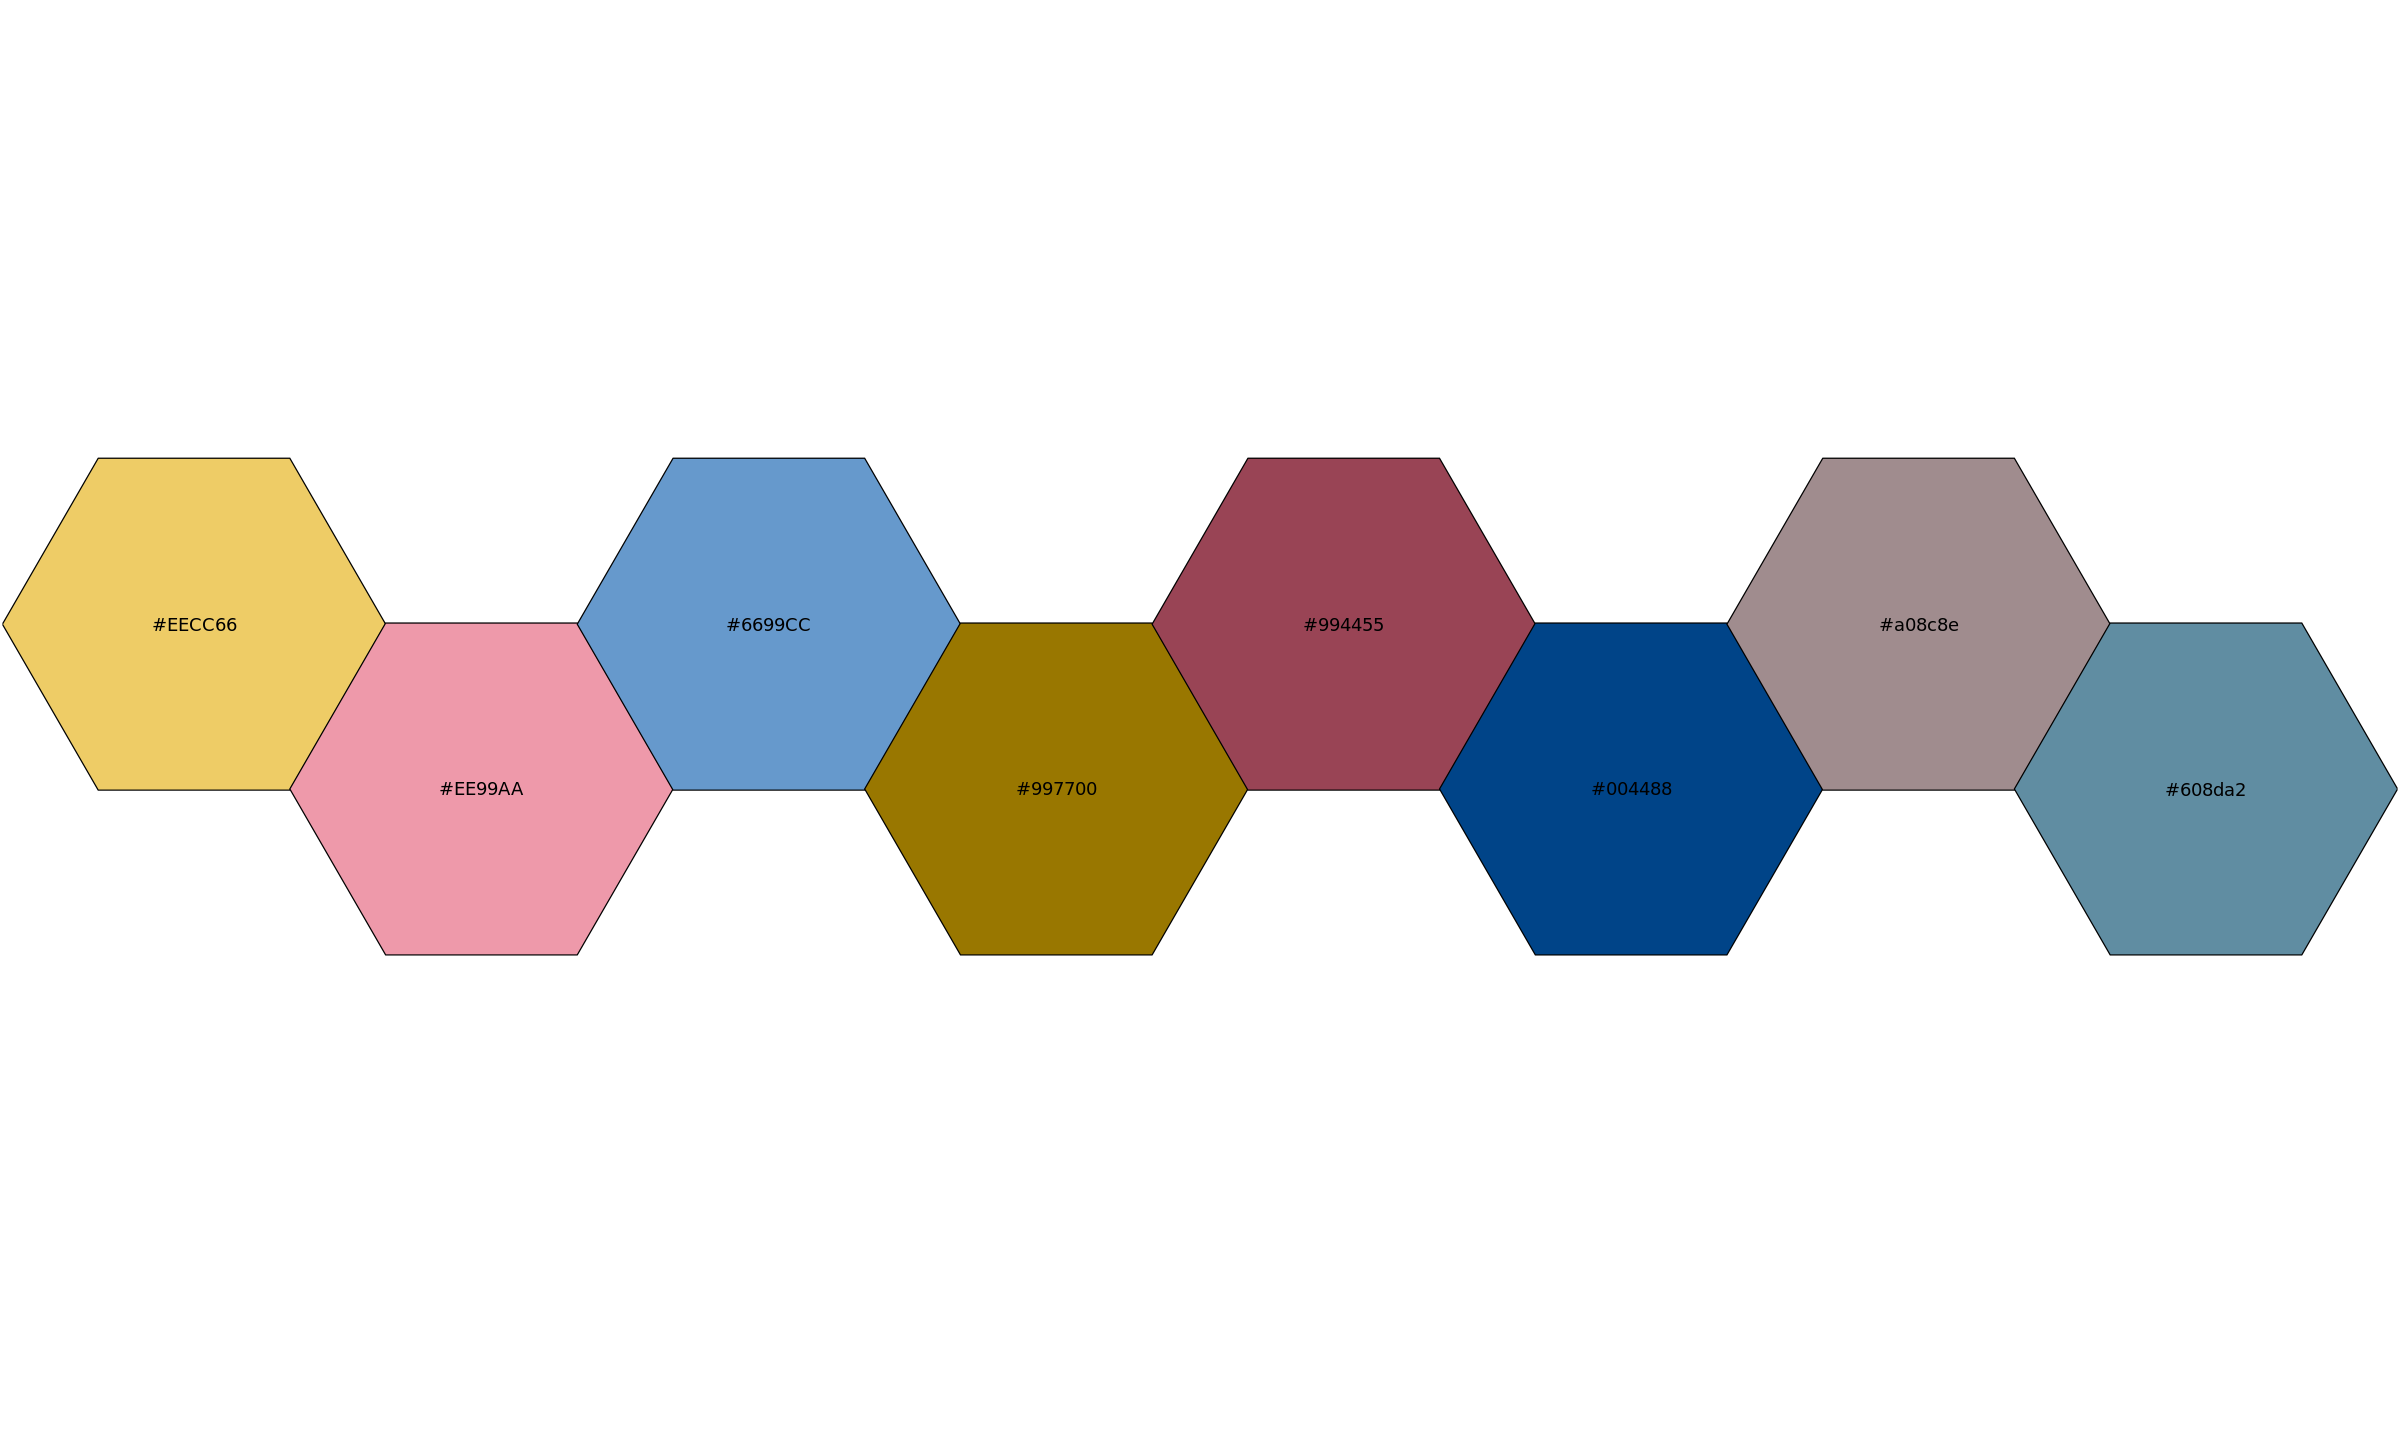

In [11]:
f_func <- "../functions.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_func, '--to=script', '--stdout'), stdout = TRUE)))
f_path <- "../dirs.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_path, '--to=script', '--stdout'), stdout = TRUE)))
f_cols <- "../cols.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_cols, '--to=script', '--stdout'), stdout = TRUE)))

In [12]:
lst_perc_root <- readRDS(paste0(INT_ReSeq, "lst_perc_root.Rdata"))[[wright_threshold]]
lst_perc_Asp <- readRDS(paste0(INT_ReSeq, "lst_perc_Asp.Rdata"))[[wright_threshold]]
lst_perc_Asp_species <- readRDS(paste0(INT_ReSeq, "lst_perc_Asp_species.Rdata"))[[wright_threshold]]
lst_perc_Asp_species_maxFP <- readRDS(paste0(INT_ReSeq, "lst_perc_Asp_species_maxFP.Rdata"))[[wright_threshold]]
lst_perc_Asp_species_sumFP <- readRDS(paste0(INT_ReSeq, "lst_perc_Asp_species_sumFP.Rdata"))[[wright_threshold]]

lst_cnt_Fungi <- readRDS(paste0(INT_ReSeq, "lst_cnt_Fungi.Rdata"))
lst_cnt_Asp <- readRDS(paste0(INT_ReSeq, "lst_cnt_Asp.Rdata"))
lst_cnt_Asp_species <- readRDS(paste0(INT_ReSeq, "lst_cnt_Asp_species.Rdata"))

classification_table <- as.matrix(read.csv(paste0(INT_ReSeq, "classification_table.csv"), header = TRUE, row.names = 1))

mt_nr_genomes <- readRDS(paste0(INT_database_stats, "mt_nr_genomes.Rdata")) #
mt_inspect <- readRDS(paste0(INT_database_stats, "mt_inspect.Rdata"))

In [13]:
sum_nr_gen_Asp <- mt_nr_genomes %>% rowSums()
meta_DB <- melt(mt_inspect[,c(1:3,6)], value.name = "nr_kmers", varnames = c("db", "type")) %>% 
    mutate(db = fct_relevel(db, dbs))  %>%  select(db)  %>% unique  %>% 
    mutate(EuPathDB_version = gsub("\\D", "", x = db))  %>% 
    mutate(EuPathDB_version = ifelse(db == "RS w/o CHM13v2", yes = "none", no = EuPathDB_version))  %>% 
    mutate(EuPathDB_version = ifelse(db %in% c("EPRS", "EPRSc2"), yes = "46", no = EuPathDB_version)) %>%
    mutate(EuPathDB_version = ifelse(EuPathDB_version == "", yes = "none", no = EuPathDB_version)) %>% 
    mutate(EuPathDB_version = ifelse(grepl(db, pattern = "MC"), 
                                           yes = paste0(EuPathDB_version, " + MycoCosm"), no = EuPathDB_version)) %>% 
    mutate(status = ifelse(grepl(db, pattern = "DM"), yes = "dustmasked", 
                    ifelse(db %in% c("EPRS", "EPRSc2"), yes = "clean", 
                    ifelse(db %in% c("EPRSFv46", "EPRSFv64","RS"), yes = "unaltered", no="")))) %>% 
    mutate(nr_genomes = as.numeric(sapply(.$db, function(x) sum_nr_gen_Asp[names(sum_nr_gen_Asp) == x]))) %>% 
    mutate(bin_genomes = ifelse(nr_genomes < 10, yes = "<10",
                         ifelse(nr_genomes >= 10 & nr_genomes < 50, yes = "10-50",
                         ifelse(nr_genomes >= 300, yes = ">300", no = NA)))) %>% 
    mutate(bin_genomes = factor(bin_genomes, levels = c("<10", "10-50", ">300", NA))) 

In [14]:
options(repr.plot.width=1.5, repr.plot.height=0.2)
meta_d_sel <- list()
for(d in dbs_sel){
    meta_d_sel[[d]] <- meta_DB %>%  
        filter(db == d) %>% 
        mutate(db = factor(db, levels = dbs_sel)) %>% 
            ggplot(aes(x = db, y = 1)) + 
                scale_fill_manual(values = c("none" = colors_mc[1], "46" = colors_mc[2], "64" = colors_mc[3], 
                         "46 + MycoCosm" = "#a08c8e", "64 + MycoCosm" = "#537490")) + 
                scale_pattern_manual(values = c(unaltered = "none", dustmasked = "stripe", clean = "crosshatch")) +
                scale_size_manual(values = c(1,5,10), breaks = c("<10", "10-50", ">300")) +
                geom_tile(fill = NA) + 
                #geom_point(aes(size = bin_genomes), color = "black") +
                theme_void() + theme(axis.text.x = element_text()) + 
                guides(pattern = "none", fill = "none", size = 'none') + scale_x_discrete(labels=c(
                                "RS_minusT2T" = "uR.7 w/o\nCHM13v2", "RS" = "uR.7 ", 
                                "EPRSc2" = "cRE.21", "EPRSFv46DM" = "dRE.21", "EPRSFv46MCAspDM" = "dREM.258", 
                                "EPRSFv64DM" = "dRE.31", "EPRSFv64MCAspDM" = "dREM.260"))
}

In [15]:
plt_in_db = plt_DB_extension = plt_decontamination = plt_heatmap_all <- list()
if(exists("Aspergillus_prct_tbl")){rm("Aspergillus_prct_tbl")}
for (i in 1:4){
    lst_perc_tmp <- list(lst_perc_Asp, lst_perc_Asp_species, lst_perc_Asp_species_sumFP, lst_perc_root)[i]
    tmp_prct_tbl <-  melt(lst_perc_tmp, value.name = "percentage", varnames = c("db", "strain")) %>% 
        #filter(grepl(strain, pattern = "Aspergillus") | grepl(strain, pattern = "Penicillium")) %>% 
        filter(db %in% dbs)  %>%
        mutate(db = factor(db, levels = dbs))  %>%  
        mutate(strain = gsub(strain, pattern = "sample[1-9]", replacement = "")) %>% 
        mutate(strain = gsub(strain, pattern = "Syn[1-9]", replacement = "")) %>% 
        mutate(strain = gsub(strain, pattern = "\\.", replacement = " "))  %>% 
        mutate(strain = gsub(strain, pattern = "Aspergillus", replacement = "Aspergillus "))  %>% 
        mutate(strain = gsub(strain, pattern = "Penicillium", replacement = "Penicillium "))  %>% 
        mutate(strain = gsub(strain, pattern = "Fusarium", replacement = "Fusarium "))  %>% 
        mutate(strain = gsub(strain, pattern = "Botrytis", replacement = "Botrytis "))  %>% 
        mutate(strain = gsub(strain, pattern = "Komagataella", replacement = "Komagataella "))  %>% 
        mutate(strain = gsub(strain, pattern = "Pneumocystis", replacement = "Pneumocystis "))  %>% 
        mutate(strain = gsub(strain, pattern = "Rhizopus", replacement = "Rhizopus "))  %>% 
        mutate(species = gsub(strain, pattern = "(?<=[a-z])([A-Z]).*", replacement = "", perl = TRUE))  %>% 
        mutate(genus = ifelse(grepl(strain, pattern = "Aspergillus"), yes = "Aspergillus", no = 
                       ifelse(grepl(strain, pattern = "Penicillium"), yes = "Penicillium", no = "Others"))) %>% 
        mutate(genus = factor(genus, levels = c("Aspergillus", "Penicillium", "Others"))) %>% 
        mutate(species = gsub(species, pattern = "costaricaensis", replacement = "costaricensis")) %>% 
        mutate(strain = gsub(strain, pattern = "(?<=[a-z])([A-Z])", replacement = " ", perl = TRUE))  %>% 
        mutate(species_in_db = "no") %>% 
        mutate(taxa = c("Asp_G", "Asp_S", "Asp_S_sumFP", "root")[i])

    for (db in dbs_sel){
        in_db_insp <- paste0(DB_DIR, db, "_inspect.txt")
        db_insp <- read.csv(file = in_db_insp, header=FALSE, sep = "\t", stringsAsFactors=FALSE)
        db_insp$V6 <-  str_trim(db_insp$V6, side = "left")    
        tmp_prct_tbl$species_in_db[which(tmp_prct_tbl$species %in% db_insp$V6 & 
                                                     tmp_prct_tbl$db == db)] <- "yes"
    }

    if(exists("Aspergillus_prct_tbl")){Aspergillus_prct_tbl <- rbind(Aspergillus_prct_tbl, tmp_prct_tbl)}
    else{Aspergillus_prct_tbl <- tmp_prct_tbl}
}
Aspergillus_prct_tbl <- Aspergillus_prct_tbl %>% mutate(species_in_db = 
                        ifelse(genus %in% c("Penicillium", "Others"), yes = "no", no = species_in_db))

In [16]:
lbls = c("Apergillus genus (% reads)", "correct Aspergillus species (% reads)",
         "sum incorrect Aspergillus species (% reads)", "classified to any taxa (% reads)")

order_Asp = order_Pen = order_Oth <- list()
for (d in dbs_sel){
    if (d %in% c("RS", "EPRSc2")){ s="Asp_S" }else{ s="Asp_G"}
    tmp_sep_Asp <- Aspergillus_prct_tbl %>% 
        filter(db == d) %>% filter(genus == "Aspergillus") %>% filter(taxa == s) 
    order_Asp[[d]] <- tmp_sep_Asp$strain[order(tmp_sep_Asp$percentage, na.last = FALSE)]
    tmp_sep_Asp <- NULL
    
    tmp_sep_Pen <- Aspergillus_prct_tbl %>% 
        filter(db == d) %>% filter(genus == "Penicillium") %>% filter(taxa == s) 
    order_Pen[[d]] <- tmp_sep_Pen$strain[order(tmp_sep_Pen$percentage, na.last = FALSE)]
    tmp_sep_Pen <- NULL
        
    tmp_sep_Oth <- Aspergillus_prct_tbl %>% 
        filter(db == d) %>% filter(genus == "Others") %>% filter(taxa == s) 
    order_Oth[[d]] <- tmp_sep_Oth$strain[order(tmp_sep_Oth$percentage, na.last = FALSE)]
    tmp_sep_Oth <- NULL
}
 
plts_sort <- list()
tmp_plts <- list()
nr <- 0
for (d in dbs_sel){
    tmp_plts[[d]] <- list()
    print(d)
    nr = nr + 1
    
    for (l in 1:3){
        heatmap_tmp <- Aspergillus_prct_tbl %>%
            mutate(strain = factor(strain, levels = c(order_Asp[[d]], order_Pen[[d]], order_Oth[[d]]))) %>% 
            filter(taxa != "root") %>% 
            filter(db == d) %>% 
            filter(taxa == c("Asp_G", "Asp_S", "Asp_S_sumFP")[l]) %>% 
            ggplot(aes(x=db)) + 
                geom_tile(data = . %>% filter(genus == "Aspergillus"),
                    aes(fill = percentage, y = strain), color = 'white', linewidth = 1) + 
                scale_fill_distiller(palette = c("Greens","Blues", "Oranges")[l], na.value = "light grey", 
                                         limits = c(100,0), trans = "reverse") +
                labs(size = "species in DB", fill = lbls[l]) + 
                new_scale_fill() +
                geom_tile(data = . %>% filter(genus == "Penicillium"),
                            aes(fill = percentage, y = strain), color = 'white', linewidth = 1) + 
                geom_tile(data = . %>% filter(genus == "Others"), 
                            aes(fill = percentage, y = strain), color = 'white', linewidth = 1) +  
                scale_fill_distiller(palette = "Purples", na.value = "light grey", limits = c(100,0), trans = "reverse") +
                facet_grid(rows = vars(genus), cols = vars(taxa), scales = "free_y", space = "free") +
                theme_void() + theme(plot.title = element_text(hjust = 0.5), axis.text.x = element_blank(),
                          axis.ticks = element_blank(), 
                          axis.title.x = element_blank(), 
                          axis.title.y = element_blank(),
                          strip.background = element_blank(), strip.text = element_blank()) +
                geom_point(data = . %>%  filter(species_in_db == "no"), aes(x=db, y=strain, col = species_in_db), size = 2) + 
                scale_color_manual(values = c("darkgrey"), breaks = c("no")) +
                scale_y_discrete(position = "right") 
            if (l==1){tmp_plts[[d]][[l]] = (heatmap_tmp + guides(fill = FALSE, color = FALSE) + labs(tag = c('a','b','c')[nr]))}
            if (l==2){tmp_plts[[d]][[l]] = (heatmap_tmp + guides(fill = FALSE, color = FALSE))}
            if (l==3){heatmap_tmp2 = heatmap_tmp + theme(axis.text.y = element_text(hjust = 0)) + 
                          labs(fill = "Non-Aspergillus, misclassified as Aspergillus (%)") + 
                          labs(color = "Species in DB")
                      tmp_plts[[d]][[l]] = (heatmap_tmp2)}
    }
}

[1] "RS"
[1] "EPRSc2"
[1] "EPRSFv64MCAspDM"


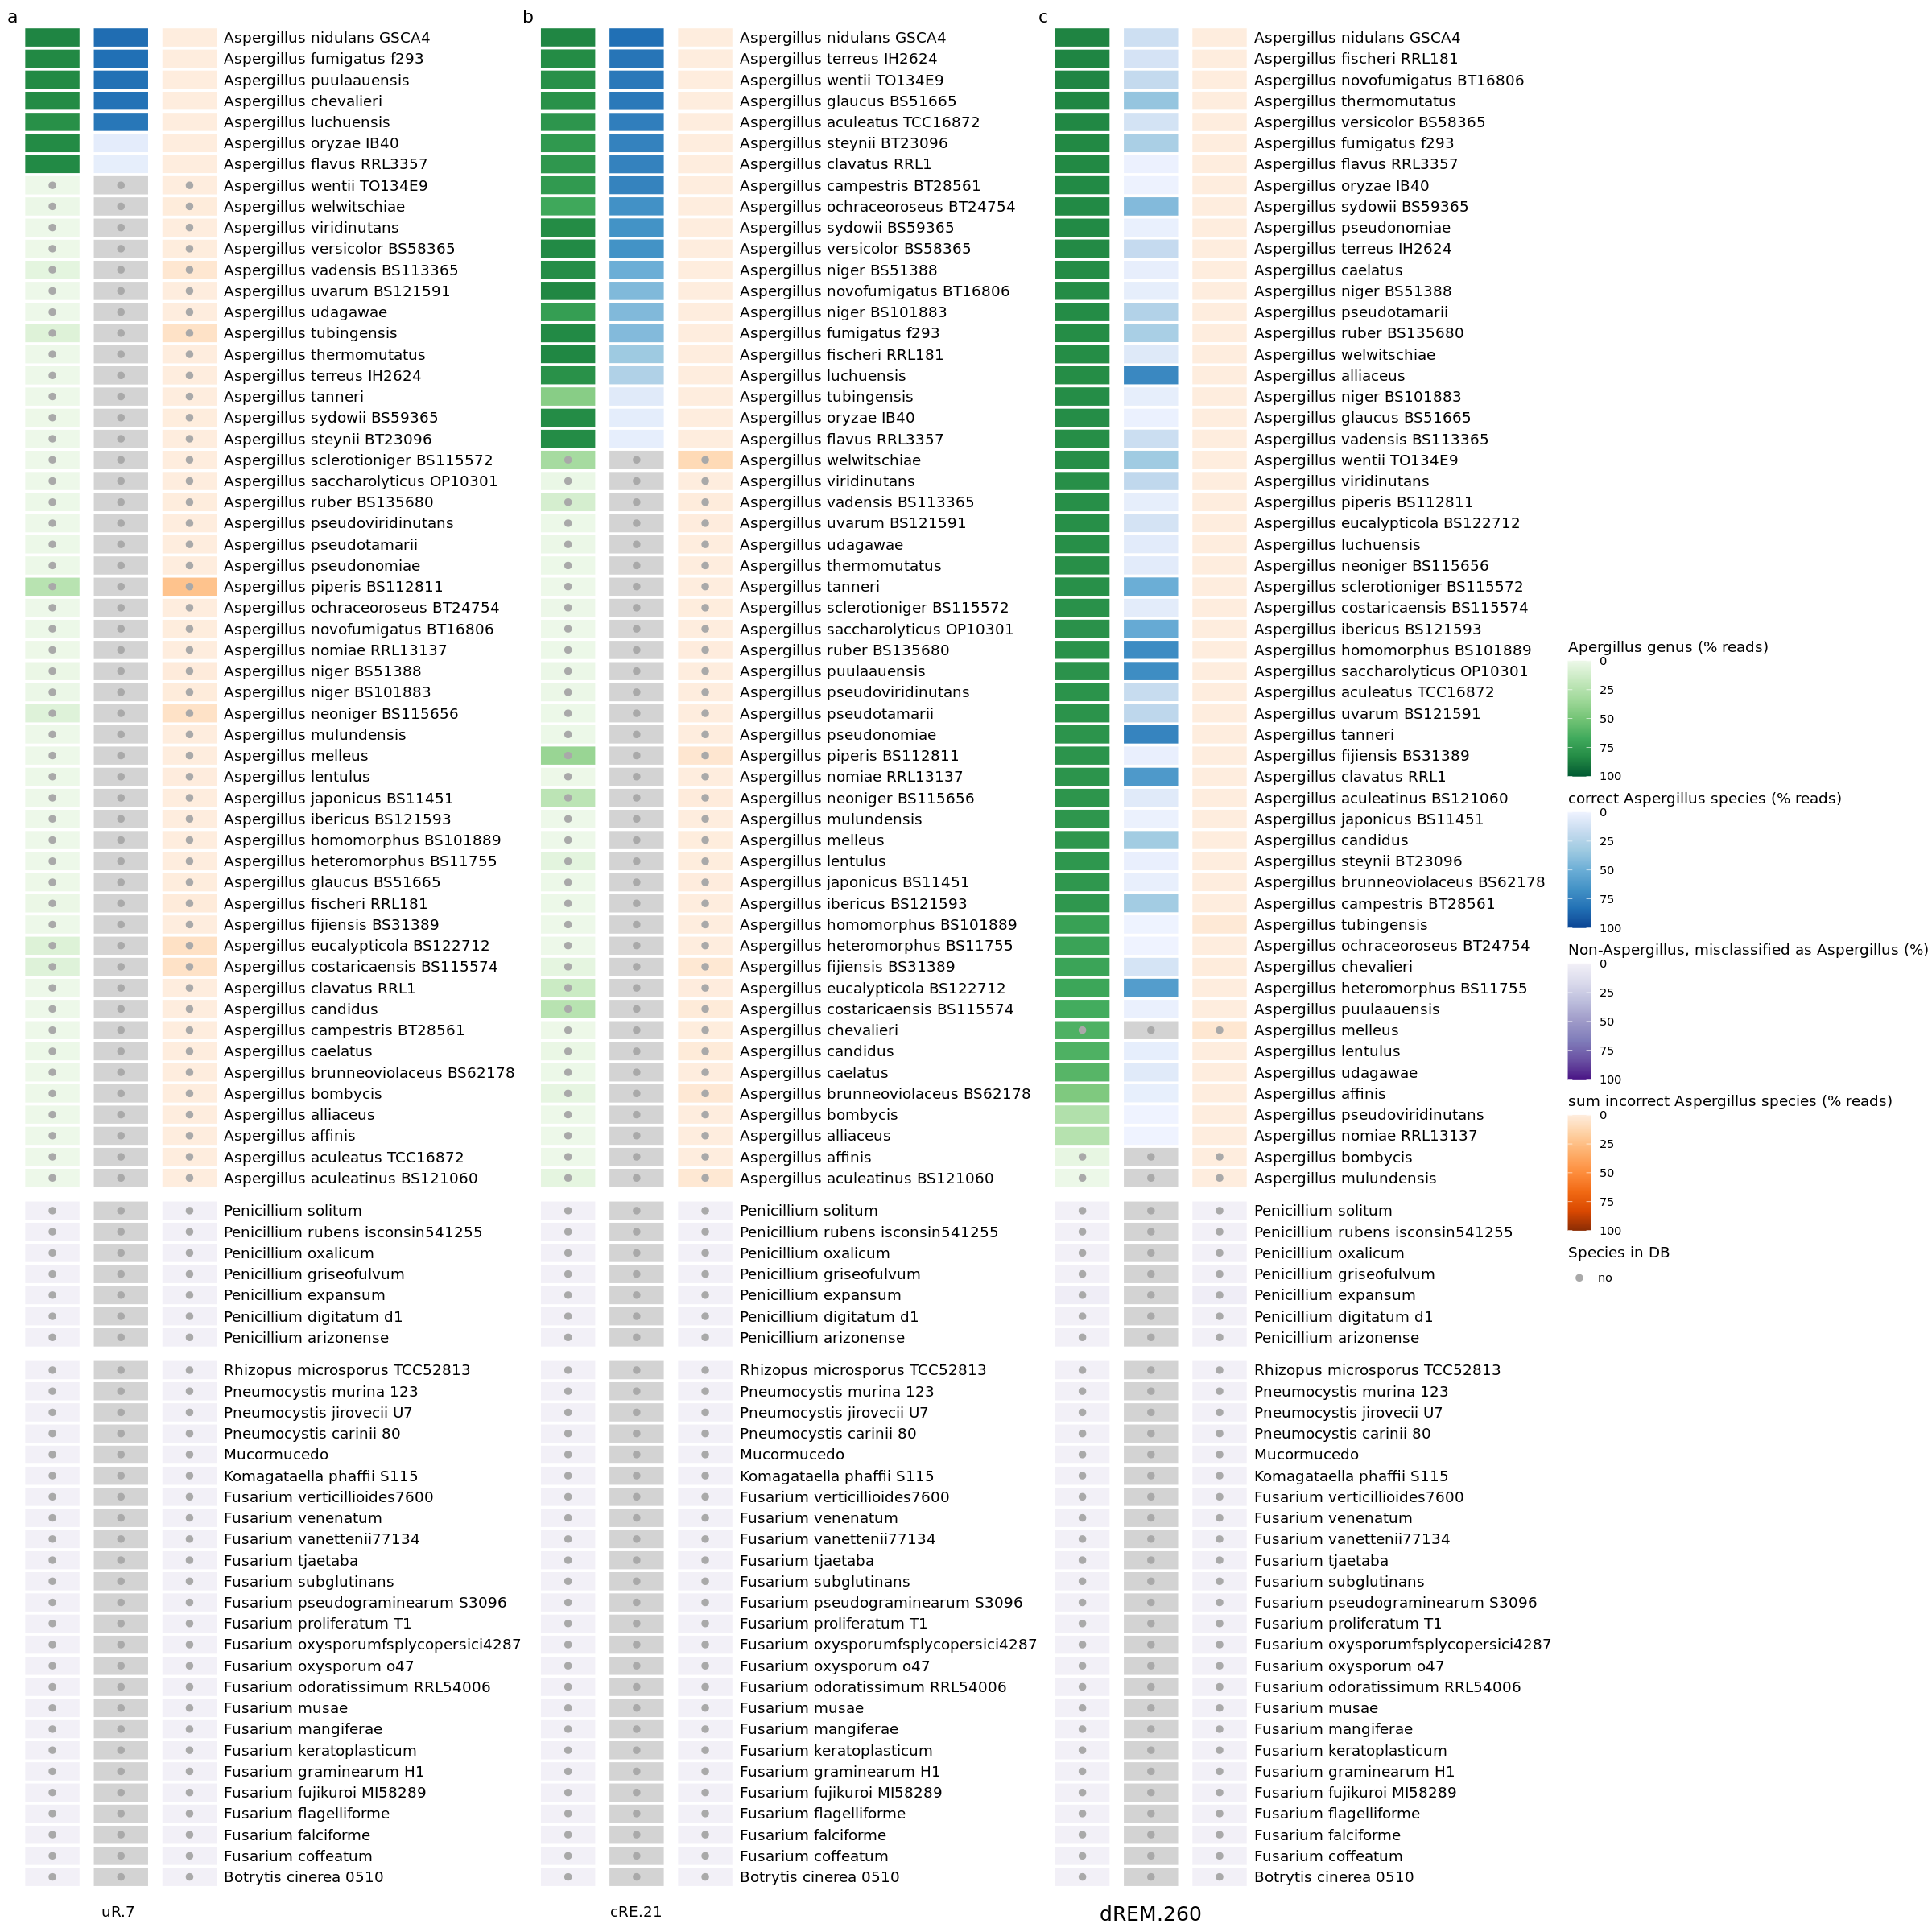

In [21]:
options(repr.plot.width=20, repr.plot.height=20)
layout= "
    ABCDEFGHI
    JJJKKKLLL"
SuplFig6 <- 
    tmp_plts[[1]][[1]] + tmp_plts[[1]][[2]] + tmp_plts[[1]][[3]] + 
    tmp_plts[[2]][[1]] + tmp_plts[[2]][[2]] + tmp_plts[[2]][[3]] + 
    tmp_plts[[3]][[1]] + tmp_plts[[3]][[2]] + tmp_plts[[3]][[3]] + 
    meta_d_sel[[1]] + meta_d_sel[[2]] + meta_d_sel[[3]] + 
        plot_layout(ncol = 9, nrow = 2, heights = c(25,0.2), guides = "collect", design = layout) + 
            theme(legend.position='right', legend.justification='center', legend.direction = 'vertical',
            axis.text.x = element_text(size = 15), 
            legend.key.size = unit(0.75, 'cm'), legend.key.height = unit(0.75, 'cm'), legend.key.width = unit(0.75, 'cm'), 
            text = element_text(size = 17), 
            legend.title = element_text(size = 18), legend.text = element_text(size = 15, colour = "black"),
            plot.title = element_text(size = 20, hjust = 0.5, face = "bold"), 
            plot.subtitle = element_text(size = 17, hjust = 0.5), 
            plot.tag = element_text(face = 'bold', size = 20))

SuplFig6

ggsave("../../output/suppl_figures/SuplFig6_R.png", 
       SuplFig6, width = 20, height = 20)
ggsave("../../output/suppl_figures/SuplFig6_R.pdf", 
       SuplFig6, width = 20, height = 20)

In [18]:
print("max percentage of Penicillium reads misclassified as Aspergillus (G)")
Aspergillus_prct_tbl %>%
            mutate(strain = factor(strain, levels = c(order_Asp[[d]], order_Pen[[d]], order_Oth[[d]]))) %>% 
            filter(taxa != "root") %>% 
            filter(taxa == "Asp_G") %>%  
            filter(genus == "Penicillium") %>% 
            filter(percentage == max(percentage))

print("max percentage of Penicillium reads misclassified as Aspergillus (sum species)")
Aspergillus_prct_tbl %>%
            mutate(strain = factor(strain, levels = c(order_Asp[[d]], order_Pen[[d]], order_Oth[[d]]))) %>% 
            filter(taxa != "root") %>% 
            filter(taxa == "Asp_S_sumFP") %>%  
            filter(genus == "Penicillium") %>% 
            filter(percentage == max(percentage))

[1] "max percentage of Penicillium reads misclassified as Aspergillus (G)"


db,strain,percentage,L1,species,genus,species_in_db,taxa
<fct>,<fct>,<dbl>,<int>,<chr>,<fct>,<chr>,<chr>
EPRSFv46MCAspDM,Penicillium expansum,1.97,1,Penicillium expansum,Penicillium,no,Asp_G
EPRSFv64MCAspDM,Penicillium expansum,1.97,1,Penicillium expansum,Penicillium,no,Asp_G


[1] "max percentage of Penicillium reads misclassified as Aspergillus (sum species)"


db,strain,percentage,L1,species,genus,species_in_db,taxa
<fct>,<fct>,<dbl>,<int>,<chr>,<fct>,<chr>,<chr>
EPRSFv46MCAspDM,Penicillium expansum,1.900496,1,Penicillium expansum,Penicillium,no,Asp_S_sumFP
EPRSFv64MCAspDM,Penicillium expansum,1.900496,1,Penicillium expansum,Penicillium,no,Asp_S_sumFP
